In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn import metrics
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/GitHub/master-thesis'

/content/drive/MyDrive/GitHub/master-thesis


In [ ]:
from clustering.utils import *

In [ ]:
#%cd ..

# Import Data

In [ ]:
df, answers_train, answers, info_dict = get_cluster_input_data_new(fa_data=True, start_train='2020-07-31', end_train='2020-12-01')
df.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,F5_no_contacts,F6_perceived_threat,gender,postnr,region,...,Q16_Other,Q16_Unsure_of_party_choice,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom
0,6.25,5.000000,2.75,3.5,4.666667,6.00,6.0,0,4700,Zealand,...,1,0,0,NaN,NaN,4,1,4,15,0
1,5.25,1.500000,1.25,5.0,1.666667,1.25,3.5,0,4000,Zealand,...,0,1,0,NaN,NaN,4,0,0,1,0
2,7.00,6.833333,5.50,6.0,4.666667,0.00,4.0,0,8543,Central,...,0,0,0,NaN,NaN,0,0,0,0,1
3,6.75,6.500000,6.75,7.0,4.000000,0.25,1.5,1,3760,Capital,...,0,0,0,NaN,NaN,0,0,1,0,0
4,6.50,7.000000,7.00,6.0,2.333333,0.25,4.5,0,4200,Zealand,...,0,0,0,NaN,NaN,0,1,0,0,0


In [ ]:
info_dict

{'cluster_input_cols': ['F0_cautious_behaviour',
  'F1_perception_advice',
  'F2_applicability_usefullness_advice',
  'F3_behaviour_others',
  'F4_consequence_advice',
  'F5_no_contacts',
  'F6_perceived_threat'],
 'data_path': 'data/preprocessing/dim_reduction/220513_fa_data.csv',
 'end_train': '2020-12-01',
 'fa_data': True,
 'pca_data': False,
 'scaler_type': 'MinMaxScaler()',
 'start_train': '2020-07-31'}

In [ ]:
behaviour_cols = info_dict['cluster_input_cols']
behaviour_cols

['F0_cautious_behaviour',
 'F1_perception_advice',
 'F2_applicability_usefullness_advice',
 'F3_behaviour_others',
 'F4_consequence_advice',
 'F5_no_contacts',
 'F6_perceived_threat']

In [ ]:
print('Time period from ' + str(min(df.date)) + ' to ' + str(max(df.date)))

Time period from 2020-08-01 00:00:00 to 2021-02-01 00:00:00


In [ ]:
answers.shape

(48933, 7)

In [ ]:
answers_train.shape

(34308, 7)

# GM clustering

## Probabilistic Approach to determine number of clusters

### Prior Distribution

In [ ]:
from scipy.stats import norm
mean = 2
std = 3
prior_dist = norm(loc=mean, scale=std)

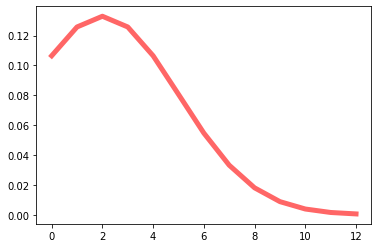

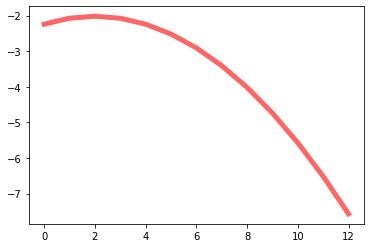

In [ ]:
x = np.arange(13)
plt.plot(x, prior_dist.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()
plt.plot(x, prior_dist.logpdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

### Calculate and Plot

In [ ]:
X = answers_train

In [ ]:
# Set up a range of cluster numbers to try
n_range = range(2,10)
list_log_prob_data_given_model = []
list_log_prob_model = []
list_score = []
list_ch_score = []
list_silhouette_score = []

# Loop through the range and fit a model
for n in tqdm(n_range):
    # init & fit gmm
    gm = GaussianMixture(n_components=n, 
                         random_state=123, 
                         n_init=6, covariance_type='tied')
    gm.fit(X)
    labels = gm.predict(X)
    ch_score = metrics.calinski_harabasz_score(X, labels)
    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
    # Calculate Log Probabilities
    log_prob_data_given_model = gm.bic(X) # Computes the per-sample average log-likelihood of the given data X - can be approximated by using BIC Score
    log_prob_model = prior_dist.logpdf(n)

    # Append values to list
    list_log_prob_data_given_model.append(log_prob_data_given_model)
    list_log_prob_model.append(log_prob_model)
    list_ch_score.append(ch_score)
    list_silhouette_score.append(silhouette_score)

100%|██████████| 8/8 [02:31<00:00, 18.89s/it]


In [ ]:
def min_max_scaler(input_list):
  input_array = np.array(input_list)
  input_array_scaled = (input_array - input_array.min()) / (input_array.max() - input_array.min())
  return input_array_scaled

In [ ]:
log_prob_data_given_model_scaled = min_max_scaler(list_log_prob_data_given_model) * - 1 # multiply with -1 so that we get a maximization problem
log_prob_model_scaled = min_max_scaler(list_log_prob_model)
score = log_prob_data_given_model_scaled + log_prob_model_scaled
score

array([0.        , 0.49876284, 0.44110033, 0.4531663 , 0.37290636,
       0.34896819, 0.19355666, 0.        ])

Text(0.5, 1.0, 'Probabilistic Evaluation')

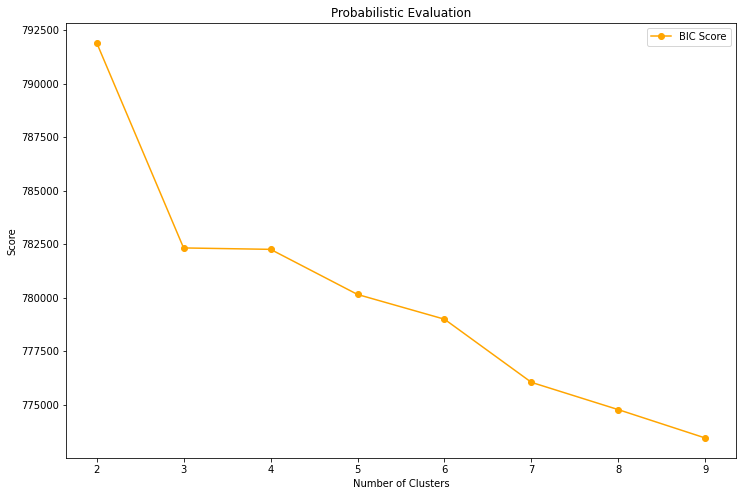

In [ ]:
# Plot Probabilistic Evaluation
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, list_log_prob_data_given_model, '-o', color='orange', label='BIC Score')
#ax.plot(n_range, log_prob_model_scaled, '-o', color='green', label='log prob model')
#ax.plot(n_range, score, '-o', color='blue', label='score')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.legend()
ax.set_title('Probabilistic Evaluation')

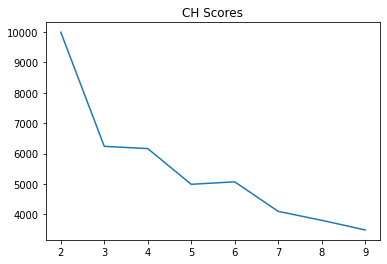

In [ ]:
plt.plot(n_range, list_ch_score)
plt.title('CH Scores')
plt.show()

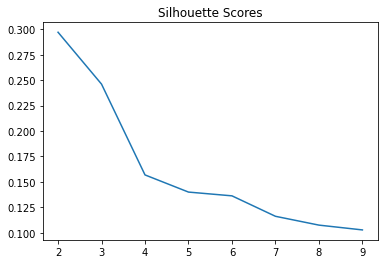

In [ ]:
plt.plot(n_range, list_silhouette_score)
plt.title('Silhouette Scores')
plt.show()

In [ ]:
n_clusters = n_range[np.argmax(score)]
n_clusters

5

## GM fit with determined number of cluster

In [ ]:
n_clusters = 5
gm = GaussianMixture(n_components=n_clusters, 
                         random_state=123, 
                         n_init=6,
                     covariance_type='tied')
gm.fit(answers_train)

GaussianMixture(covariance_type='tied', n_components=5, n_init=6,
                random_state=123)

In [ ]:
df['group'] = gm.predict(answers)
df['group_prob'] = pd.DataFrame(gm.predict_proba(answers)).max(axis=1)
df.head()

,F0_cautious_behaviour,F1_perception_advice,F2_applicability_usefullness_advice,F3_behaviour_others,F4_consequence_advice,F5_no_contacts,F6_perceived_threat,gender,postnr,region,...,Q16_Venstre,Vaccination_Status,Willingness_Vaccination,Q4_1_nr_contact_nonhouse_family,Q4_2_nr_contact_colleagues,Q4_3_nr_contact_friends,Q4_4_nr_contact_strangers,Q7_last_week_symptom,group,group_prob
0,6.25,5.000000,2.75,3.5,4.666667,6.00,6.0,0,4700,Zealand,...,0,NaN,NaN,4,1,4,15,0,4,0.999455
1,5.25,1.500000,1.25,5.0,1.666667,1.25,3.5,0,4000,Zealand,...,0,NaN,NaN,4,0,0,1,0,0,0.999836
2,7.00,6.833333,5.50,6.0,4.666667,0.00,4.0,0,8543,Central,...,0,NaN,NaN,0,0,0,0,1,1,0.727814
3,6.75,6.500000,6.75,7.0,4.000000,0.25,1.5,1,3760,Capital,...,0,NaN,NaN,0,0,1,0,0,1,0.520534
4,6.50,7.000000,7.00,6.0,2.333333,0.25,4.5,0,4200,Zealand,...,0,NaN,NaN,0,1,0,0,0,2,0.752926


In [ ]:
df_sample = df.sample(20000) # used only for quick results, must be changed back to only df to get real score

X = df_sample[behaviour_cols].to_numpy()
labels = df_sample.group.to_numpy()
metrics.silhouette_score(X, labels, metric='euclidean')

0.1350161146327363

GMM Silhouette Scores:
- 2 Cluster: 0.20
- 3 Cluster: 0.06
- 4 Cluster: 0.02

## Save for general clustering evaluation

In [ ]:
df.to_csv('data/clustering/220516_gmm_clustered_fa_data_5cluster_tied.csv', index=False)

## Dirichlet Process
n_components=20 --> 4 weights that are smaller than 0.01

In [ ]:
n_comp = 30
bgm = BayesianGaussianMixture(n_components=n_comp, random_state=123, n_init=100, weight_concentration_prior_type='dirichlet_process', weight_concentration_prior= 100)
bgm.fit(answers_sampled)

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 100 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


BayesianGaussianMixture(n_components=30, n_init=100, random_state=123,
                        weight_concentration_prior=100)

In [ ]:
labels_test = bgm.predict(answers_sampled)
print(set(labels_test))

{0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


In [ ]:
DPGMM = BayesianGaussianMixture(n_components=15, 
                                                max_iter=100000000,
                                                n_init=10,
                                                tol=1e-5, 
                                                init_params='kmeans', 
                                                weight_concentration_prior_type='dirichlet_process',
                                                weight_concentration_prior=1/10)
DPGMM.fit(answers_sampled)

BayesianGaussianMixture(max_iter=100000000, n_components=15, n_init=10,
                        tol=1e-05, weight_concentration_prior=0.1)

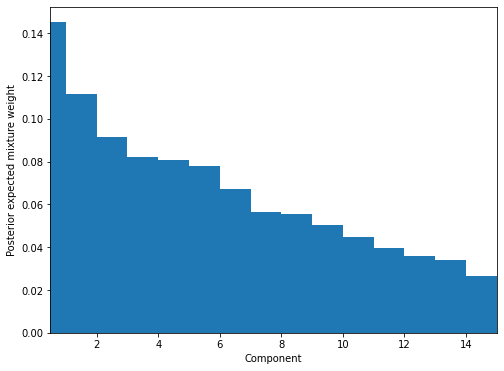

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(15) + 1

ax.bar(plot_w - 0.5, np.sort(DPGMM.weights_)[::-1], width=1., lw=0);

ax.set_xlim(0.5, 15);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [ ]:
#n_to_select = 8
w = (-DPGMM.weights_).argsort()[:n_to_select]

In [ ]:
w

In [ ]:
df['group'] = DPGMM.predict(answers)
df['group_prob'] = pd.DataFrame(DPGMM.predict_proba(answers)).max(axis=1)
df.head()

In [ ]:
mat = []
for ind2 in w:
    p1 = sp.multivariate_normal.pdf(mix,mean=DPGMM.means_[ind2],cov=DPGMM.covariances_[ind2]) + eps
    mat.append(p1)
clusts = pd.DataFrame(mat).T.idxmax(axis=1)

In [ ]:
fig, ax = plt.subplots()


scatter = ax.scatter(X[:, 0], X[:, 1], c=clusts, cmap=plt.cm.viridis, alpha=.25);
plt.title("DPGMM Predicted Labels with %s clusters" %len(np.unique(clusts)));
plt.xlabel('PCA1')
plt.ylabel('PCA2')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
ax.add_artist(legend1)

In [ ]:
bgm.weights_ # 10 comp, weight_concentration_prior = 0.01

array([0.09972451, 0.21158215, 0.02671422, 0.08405336, 0.06169124,
       0.04720168, 0.10768013, 0.14968287, 0.13016821, 0.08150162])

In [ ]:
bgm.means_

array([[5.98973420e-01, 8.27125717e-01, 9.99985800e-01, 8.03490588e-01,
        9.99986485e-01, 5.23705233e-01, 3.84195303e-01, 7.77848472e-01,
        6.73037734e-01, 5.70717866e-01, 7.42757909e-01, 6.81892157e-01,
        6.60773135e-01, 6.09051551e-01, 7.43799172e-01, 2.04374130e-01,
        8.05546728e-01, 5.90505866e-01, 7.47577430e-01, 7.13403989e-01,
        4.79381704e-01, 6.81496596e-01, 4.46020082e-01],
       [6.14103597e-01, 7.18430877e-01, 8.45995352e-01, 7.02855527e-01,
        8.33390187e-01, 6.27353529e-01, 4.89142901e-01, 8.58816394e-01,
        7.48501366e-01, 6.38480870e-01, 8.20576417e-01, 7.39849540e-01,
        7.18544313e-01, 6.99116459e-01, 7.79198550e-01, 2.73167014e-01,
        7.70819149e-01, 5.89461123e-01, 7.30673030e-01, 6.22360378e-01,
        6.22390141e-01, 6.06712979e-01, 9.99829906e-01],
       [5.80270731e-01, 6.63134946e-01, 7.48553556e-01, 6.62096828e-01,
        7.83139966e-01, 5.81117107e-01, 4.66936204e-01, 8.33342114e-01,
        6.95065484e-01

In [ ]:
bgm.n_features_in_

23

# Specific Clustering Method Analysis

In [ ]:
gm.weights_

array([0.28843901, 0.44322344, 0.26833755])

In [ ]:
df['group'].value_counts(dropna=False)

1    54541
0    36294
2    31994
Name: group, dtype: int64

## Group Probability

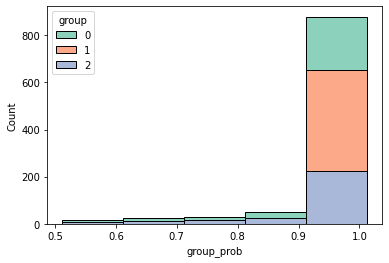

In [ ]:
df_sample = df.sample(1000)
sns.histplot(data=df_sample, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
plt.show()

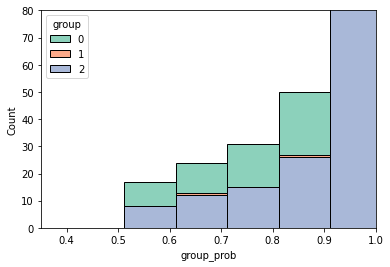

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data=df_sample, ax=ax, multiple='stack', x="group_prob", hue="group", log_scale=(False, False), binwidth=0.1, palette='Set2')
ax.set_xlim(0.35, 1)
ax.set_ylim(0,80)
plt.show()

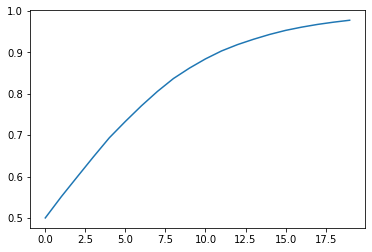

In [ ]:
prob_list = []
for i in np.arange(0, 0.2, 0.01):
  prob = df['group_prob'].quantile(i)
  prob_list.append(prob)

plt.plot(prob_list)
plt.show()